In [1]:
# default_exp data.core_pd

In [1]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [3]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load_pd import *

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [4]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [5]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [8]:
# export

class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = {}, {}

    def encodes(self, o):
        for i in range(len(o)-1):
            if type(o[i]) == TensorCon and o[i].shape[-1]>0:
                self.m[i] = torch.mean(o[i])
                self.s[i] = torch.std(o[i]) +self.eps
            elif type(o[i]) == TensorSeqs :
                self.m[i] = torch.mean(o[i], -1, keepdim=True)
                self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            else:
                print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                self.m[i], self.s[i] = 0, 1
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0]         
            
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
            
        return TSMulti([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])              

    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

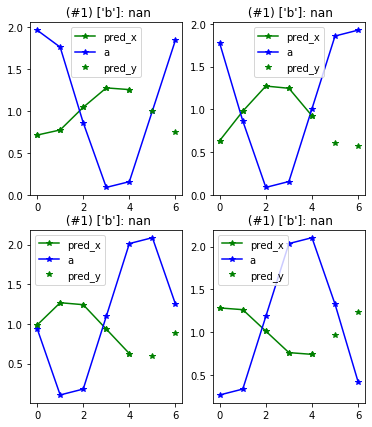

In [9]:
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        test_close(a.mean(),0)
        test_close(a.std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti)

dl.show_batch(max_n = 4)

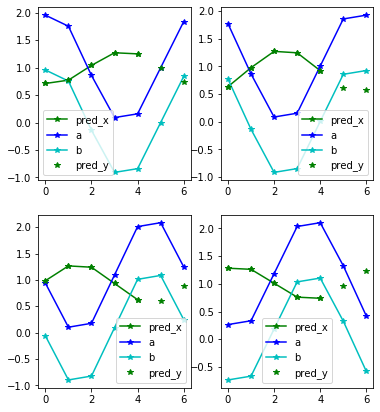

In [11]:
# hide
# basic
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,5)],'a':[i+a for i in range(1,5)],'b':[a for _ in range(1,5)]})
dl = DfDataLoader(df,'pred', horizon = horizon, lookback = lookback,after_batch=NormalizeTSMulti(),
                  num_workers = 1)
for o in dl:
    for a in o[:-1]:
        for i in range(a.shape[0]):
            test_close(a[i].mean(),0)
            test_close(a[i].std(),1,.1)
    test_eq(dl.after_batch[0].s[0], dl.after_batch[0].s[len(o)-1])
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()),TSMulti)

dl.show_batch(max_n = 4)

# TSDataLoaders

## Utils

In [12]:
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [13]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [14]:
# export
def make_test_df(df:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the series in `df` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.

    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = {}, {}  
    for col in df:
        train[col], val[col] = [], []        
        if type(df.loc[0, col])==pd.Series or type(df.loc[0, col]) == np.ndarray:
            for row in df[col]:
                val[col].append(row.flatten()[-(horizon+lookback):])
                if keep_lookback:
                    train[col].append(row.flatten()[:-(horizon)])
                else:
                    train[col].append(row.flatten()[:-(horizon+lookback)])
        else:
            val[col]   = df[col]
            train[col] = df[col]

    return pd.DataFrame(train), pd.DataFrame(val)


In [15]:
# hide
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
train, val = make_test_df(df, 5, 2)
test_eq(train.loc[0,'x'].shape, (63,))
train.head()

,x,weather,city,cont
0,"[-0.032427085338476914, -0.04537085831229835, -0.27849922413485206, -0.10893588701329099, -0.41353494205447083, -0.11552137533726185, 0.052481805417320455, 0.06031831681720666, 0.7290811220480876, 0.8418821218662482, 1.1510292595521667, 1.461254744610875, 1.5425345175591345, 2.086607499433199, 2.206392637299456, 2.1773063411587232, 2.25372013563842, 2.0787176680074686, 1.7276975566761483, 1.6018186150208098, 1.2058061450940272, 0.7522378041002389, 0.7575886488808622, 0.17870563010092833, -0.41894111521714456, -0.4935090497510159, -0.29983903897581743, -0.14691057871235108, -0.2841400795379...","[3.911953444600556, 3.6320784093936243, 3.239919283335362, 2.8037503185622477, 2.3965470515644722, 2.085562381032336, 1.9227371794953267, 1.9372577874391177, 2.1312801030753095, 2.479409131640132, 2.932012091988874, 3.4219215987141345, 3.87362361789968, 4.213685340539659, 4.381006823520802, 4.3355004787403235, 4.064011635743119, 3.5826633244390313, 2.93528925359901, 2.188145830799699, 1.4215958726460487, 0.7198656441098596, 0.16023780631038198, -0.19687952337628367, -0.3156836190680328, -0.18947836967627651, 0.15865065888850882, 0.6790706854816269, 1.302304895842473, 1.948299043177689, 2.5...",0,-0.227817
1,"[-2.783294056322711, -2.6484774368043977, -2.322372210965617, -2.0913419994929114, -1.9028672351996918, -1.6630520084503566, -1.3950843101067003, -1.2232278581567138, -1.0020714434005973, -0.9017270094619874, -0.7886415418723628, -0.6479496267542703, -0.5512565252329011, -0.4123288563126914, -0.4335427363641908, -0.2991899925693906, -0.16227848448009569, -0.15327992629314155, -0.005167870410475865, 0.16874951459964524, 0.3623554705377849, 0.16064693991816767, 0.19426142700069102, 0.11730761225676109, 0.04059037549130588, -0.011162266559727976, -0.06414787591595073, -0.05112211501079591, -0...","[8.377897601179022, 8.252784690393256, 8.279427481768373, 8.502388147357264, 8.890481978577096, 9.34137233864978, 9.710227504619628, 9.854148575711596, 9.678947816775256, 9.173761434258122, 8.422300676269256, 7.586329495701267, 6.865202293663748, 6.442541531550215, 6.4352014647404285, 6.859303900209215, 7.623408948539785, 8.551160363508783, 9.427280338404495, 10.054069233683835, 10.302567595247707, 10.144139265643542, 9.653955571062163, 8.986007305042795, 8.327439836880787, 7.845799037431212, 7.644511080417717, 7.739130280020688, 8.060455063518669, 8.482489165506706, 8.865856593111467, 9.1...",0,-0.678796
2,"[2.2906769981203357, 2.074819242935923, 1.8544696818291762, 1.642227162171589, 1.4559238086545132, 1.3761868258756724, 1.3043543303626008, 1.2111033001078755, 1.19030644089195, 1.2266508985069153, 1.1035121611522307, 1.0851799614072717, 1.036707599651351, 0.9811484362737606, 0.8915525451543992, 0.8101096051947546, 0.7160496544595574, 0.7415145045547011, 0.7420260266489951, 0.6430962921216435, 0.6705954167555933, 0.5249443985192467, 0.3490581300486696, 0.31710493851954946, 0.13737906924494542, -0.016460963002858688, -0.09050659883109832, -0.14100374932691273, -0.22885892470089322, -0.286981...","[8.188240300260173, 7.5876670889095745, 6.937016904551409, 6.441157527151595, 6.258040194878443, 6.449649314051708, 6.961778186786271, 7.638745643832439, 8.268696808075354, 8.645962927649947, 8.63183702659585, 8.195587528346566, 7.4234419049241165, 6.49285673464377, 5.619778542802601, 4.994679941902245, 4.726507717758453, 4.81129979652942, 5.134829680878971, 5.508436538236046, 5.727252588634984, 5.633326593907179, 5.164674147732989, 4.375501947997419, 3.4214911639502428, 2.5144966727062963, 1.8601872261307797, 1.597269800183811, 1.7564759714320983, 2.251578267853567, 2.905120111132849, 3.5...",0,0.491867
3,"[-2.0620989641255485, -2.000210543168143, -2.025742386316461, -1.6620176135516622, -1.6645663422863066, -1.4573457113129167, -1.4774056107953815, -1.4006478160179607, -1.3704671648617959, -1.4921034060742073, -1.2682786791618914, -1.168321291375834, -1.225892425154815, -0.8570899693775583, -0.8571282263227951, -0.64435392

In [16]:
a = pd.DataFrame({'a':[np.arange(0,15)]*50,'b':[np.arange(0,15)]*50, 'c':[3]*50})
train, val = make_test_df(a,5,2)
test_eq(train['a'][0].max(),7)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                          a                         b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7]  [0, 1, 2, 3, 4, 5, 6, 7]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

In [17]:
# hide
train, val = make_test_df(a,5,2,True)
test_eq(train['a'][0].max(),9)
test_eq(val['a'][0].min(),8)
test_eq(val['c'][0],val['c'][1])
train.head(), val.head()

(                                a                               b  c
 0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  3,
                             a                           b  c
 0  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 1  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 2  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 3  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3
 4  [8, 9, 10, 11, 12, 13, 14]  [8, 9, 10, 11, 12, 13, 14]  3)

## Dataloaders

In [18]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            make_ones = kwargs.pop('make_ones', True)
            kwargs.update({'after_batch':L(NormalizeTSMulti(make_ones=make_ones))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step, device=device, norm = False, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, name='test', device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [19]:
# hide
# device `cpu`
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[i + (i*.6)*a*-.5 for i in range(1,100)],'a':[i+a for i in range(1,100)]})


In [20]:
# hide
data = DfDataLoaders.from_df(df, 'pred', horizon = horizon, lookback=lookback, step=5, device = torch.device('cpu'))
test_eq(data.valid.dataset.iloc[0,0].shape[-1],data.valid.dataset.iloc[0,1].shape[-1])
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], torch.device('cpu'))
test_eq([o[0].device for o in data.test][0], torch.device('cpu'))

Train:396; Valid: 99; Test 99


In [21]:
# hide
# default device

data = DfDataLoaders.from_df(df,'pred', horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset.iloc[0,0].shape[-1]>lookback+horizon, True)
test_eq(hasattr(data,'test'),True)
test_eq([o[0].device for o in data.train][0], default_device())
test_eq([o[0].device for o in data.test][0], default_device())

Train:396; Valid: 99; Test 99


In [22]:
# hide
dbunch = DfDataLoaders.from_df(df,'pred',horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

Train:1881; Valid: 396


In [23]:
show_doc(DfDataLoaders.from_df, name='DfDataLoaders.from_df')

<h4 id="DfDataLoaders.from_df" class="doc_header"><code>DfDataLoaders.from_df</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>DfDataLoaders.from_df</code>(**`dataset`**:`DataFrame`, **`y_name`**:`str`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`min_seq_len`**=*`None`*, **`max_std`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series.
The `DataLoader` for the test set will be save as an attribute under `test`

In [24]:
from fastseq.data.external import *
horizon,lookback = 5,10
df = dummy_data_generator_multi(70)
df['city'] = df['city'].astype(float)
df.head(3)

,x,weather,city,cont
0,"[[0.44909188283953083, 0.3764653821755658, -0.12933059457620757, -0.1313831023783668, -0.5306923643513981, -0.18399136552708897, -0.3929576716200954, -0.2143826341931859, 0.007048119389051284, 0.5147814064530871, 1.123267573139444, 1.4525040156896079, 2.022881827318481, 2.3148157595369727, 1.9730152620499648, 2.3893399648407483, 2.087755823782159, 2.250675500925644, 1.8991173687809566, 1.4380424273084509, 1.8465278071169844, 1.2772879739909933, 0.7901608564225232, 0.747329832811429, 0.5529017827661161, -0.4148963392326295, -0.3755459238187693, -0.6275864545106625, -1.061668507761116, -0.37...","[[1.6786711628247126, 1.509416504051722, 1.3025631750642446, 1.1308083754197265, 1.0671006989496108, 1.1662967914970945, 1.4497428108556372, 1.8971393161620673, 2.448261951566246, 3.0145385478077733, 3.497844116967504, 3.811915918638441, 3.901069809847341, 3.751622735127426, 3.3933880971189305, 2.8912523040940057, 2.329414678365382, 1.792660983959196, 1.3495621573123082, 1.0416373783354098, 0.8805867295173215, 0.8532824830618984, 0.9320333037132649, 1.0863339630942943, 1.2922374335479967, 1.536609935219816, 1.815461257198999, 2.1276508251152215, 2.466878999204444, 2.8154717867351504, 3.142...",0.0,-0.208734
1,"[[0.8859774057969569, 1.3677148679023328, 1.0928791672666296, 1.0415320592014792, 1.469267684577613, 0.5512736568631187, 1.2461400264818028, 1.1720437792070644, 0.34147572682782545, 0.9436093604777609, 0.3896869053166532, 0.24986383649664998, 0.5052563502822239, 0.4691445532523829, 0.3314640954704887, 0.10404813364636008, -0.2725789995879034, -0.5507862794069002, -0.08431881503901488, -0.22052176650656763, -0.11760888081372813, -0.10734700834026777, -0.0030614559238625904, -0.603125497000097, -0.38919961351482335, 0.025877611364714337, -0.19071009274456815, 0.26068506267755404, -0.10506797...","[[4.796666160788716, 4.69031166307619, 4.533037955600139, 4.334507020775194, 4.109398962312138, 3.875478236042124, 3.6512605202807817, 3.4535930782730784, 3.295472639568376, 3.1843923338042837, 3.1214374518718775, 3.10124848763608, 3.1128527187810158, 3.1412483478874353, 3.1695237759322277, 3.1812226148473175, 3.1626322724765368, 3.104684774305967, 3.0042114415853765, 2.864380953065009, 2.6942612832587454, 2.507565024322774, 2.320748564325216, 2.150723502289119, 2.0124916356337392, 1.9170256866749797, 1.8696851615479035, 1.86938476936143, 1.9086313804779858, 1.9744282653481697, 2.049928160...",0.0,1.032587
2,"[[1.2633162928427448, 0.6636093649094353, -0.3639695422562113, -0.5851605292053949, -1.0822648548474454, -0.8501187106444626, -1.512939343819763, -1.2191929288983891, -1.1449064678223844, -0.8318667625293029, -0.6345953445801645, -0.06951230458683402, 0.7260347367264615, 0.7896683243683809, 1.402707530547192, 1.3008185278567004, 1.906138192132467, 1.295000552997466, 1.0839120581009454, 0.7954887057646902, 0.43422867435396306, 0.3127525541447716, -0.5139471482626315, -0.6637817828793339, -0.5042821345536677, -1.0566080799877644, -1.2266671000461273, -1.095817324708913, -1.1199127967654996, ...","[[11.251583569509117, 10.979830311595622, 10.58947346868561, 10.150098420721948, 9.736668239627576, 9.418831339478418, 9.251008560515602, 9.264615729881047, 9.463486646860238, 9.823126022343367, 10.293901075185714, 10.80774471432593, 11.287465004773887, 11.6573996508675, 11.853968741781843, 11.834689174028522, 11.584418741719674, 11.117969346958759, 10.478717053412172, 9.733375913761115, 8.963619872416913, 8.25566272978413, 7.689182662367629, 7.327067755255159, 7.2073502209850595, 7.338404071719818, 7.698043447202906, 8.23663556628963, 8.883803909065431, 9.557816327663062, 10.1763941410239...",0.0,-1.062155


Train:130; Valid: 60; Test 10


ValueError: only one element tensors can be converted to Python scalars

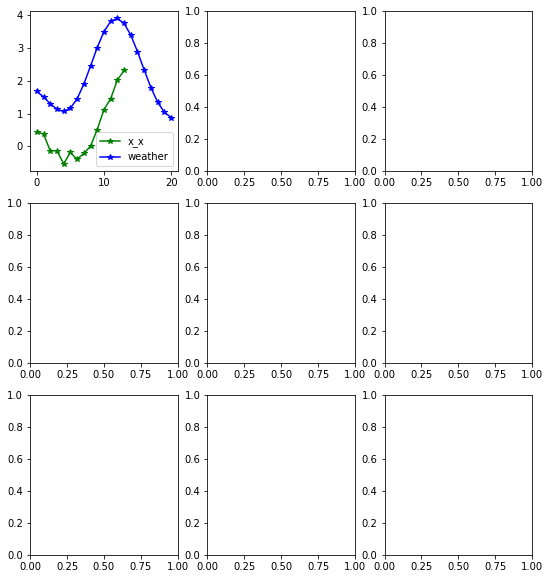

In [25]:
dbunch =  DfDataLoaders.from_df(df, 'x', horizon = 7, lookback=14, step=2, bs=32)
dbunch.train.show_batch(max_n=9)

ValueError: only one element tensors can be converted to Python scalars

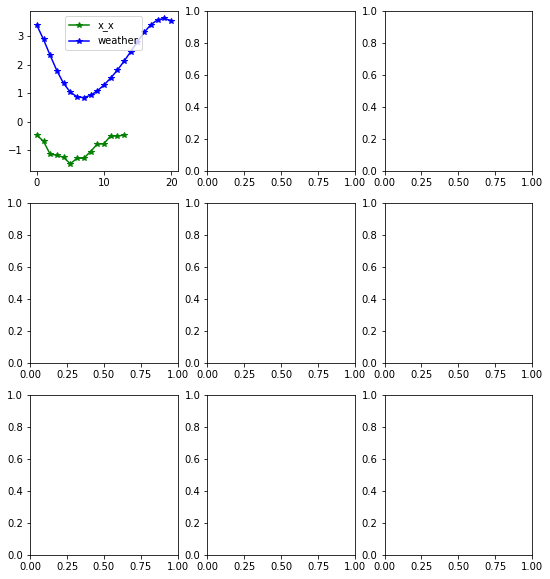

In [26]:
dbunch.test.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()